# Feature Engineering
Chapter 4 of the book: "Build Your Own AI Investor"

In [2]:
from platform import python_version
print(python_version())

3.9.7


In [3]:
# Code from Book: Build Your Own AI Investor
# Damon Lee 2021
# Check out the performance on www.valueinvestingai.com
# Code uses data from the (presumably) nice people at https://simfin.com/. 
# Feel free to fork this code for others to see what can be done with it.

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

In [4]:
# Set the plotting DPI settings to be a bit higher.
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

# Read in Stock Data from last notebook

In [5]:
# In this notebook we will use x_ for x fundamentals,
# and X is the input matrix we want at the end.
x_=pd.read_csv('Annual_Stock_Price_Fundamentals_Filtered.csv',
               index_col=0)
y_=pd.read_csv('Annual_Stock_Price_Performance_Filtered.csv',
               index_col=0)

# Get Fundamental Ratios

In [14]:
def addColsToX(x):
    '''
    Takes in x DataFrame, edits it to include:
        Enterprise Value.
        Earnings before interest and tax.
    
    '''
    x['EV'] = x['Market Cap'] \
    + x['Long Term Debt'] \
    + x['Short Term Debt'] \
    - x['Cash, Cash Equivalents & Short Term Investments']

    x['EBIT'] = x['Net Income_x'] \
    - x['Interest Expense, Net'] \
    - x['Income Tax (Expense) Benefit, Net']

In [16]:
# Make new X with ratios to learn from.
def getXRatios(x_):
    '''
    Takes in x_, which is the fundamental stock DataFrame raw. 
    Outputs X, which is the data encoded into stock ratios.
    '''
    X=pd.DataFrame()
    
    # EV/EBIT
    X['EV/EBIT'] = x_['EV'] / x_['EBIT']
    
    # Op. In./(NWC+FA)
    X['Op. In./(NWC+FA)'] = x_['Operating Income (Loss)'] \
    / (x_['Total Current Assets'] - x_['Total Current Liabilities'] \
       + x_['Property, Plant & Equipment, Net'])
    
    # P/E
    X['P/E'] = x_['Market Cap'] / x_['Net Income_x']
    
    # P/B
    X['P/B'] = x_['Market Cap'] / x_['Total Equity'] 
    
    # P/S
    X['P/S'] = x_['Market Cap'] / x_['Revenue'] 
    
    # Op. In./Interest Expense
    X['Op. In./Interest Expense'] = x_['Operating Income (Loss)']\
    / - x_['Interest Expense, Net']
    
    # Working Capital Ratio
    X['Working Capital Ratio'] = x_['Total Current Assets']\
    / x_['Total Current Liabilities']
    
    # Return on Equity
    X['RoE'] = x_['Net Income_x'] / x_['Total Equity']
    
    # Return on Capital Employed
    X['ROCE'] = x_['EBIT']\
    / (x_['Total Assets'] - x_['Total Current Liabilities'] )
    
    # Debt/Equity
    X['Debt/Equity'] = x_['Total Liabilities'] / x_['Total Equity']
    
    # Debt Ratio
    X['Debt Ratio'] = x_['Total Assets'] / x_['Total Liabilities']
    
    # Cash Ratio
    X['Cash Ratio'] = x_['Cash, Cash Equivalents & Short Term Investments']\
    / x_['Total Current Liabilities']
    
    # Asset Turnover
    X['Asset Turnover'] = x_['Revenue'] / \
                            x_['Property, Plant & Equipment, Net']
    
    # Gross Profit Margin
    X['Gross Profit Margin'] = x_['Gross Profit'] / x_['Revenue']
    
    ### Altman ratios ###
    # (CA-CL)/TA
    X['(CA-CL)/TA'] = (x_['Total Current Assets']\
                       - x_['Total Current Liabilities'])\
                        /x_['Total Assets']
    
    # RE/TA
    X['RE/TA'] = x_['Retained Earnings']/x_['Total Assets']
    
    # EBIT/TA
    X['EBIT/TA'] = x_['EBIT']/x_['Total Assets']
    
    # Book Equity/TL
    X['Book Equity/TL'] = x_['Total Equity']/x_['Total Liabilities']
    
    X.fillna(0, inplace=True)
    return X

def fixXRatios(X):
    '''
    Takes in X, edits it to have the distributions clipped.
    The distribution clippings are done manually by eye,
    with human judgement based on the information.
    '''
    X['RoE'].clip(-5, 5, inplace=True)
    X['Op. In./(NWC+FA)'].clip(-5, 5, inplace=True)
    X['EV/EBIT'].clip(-500, 500, inplace=True)
    X['P/E'].clip(-1000, 1000, inplace=True)
    X['P/B'].clip(-50, 100, inplace=True)    
    X['P/S'].clip(0, 500, inplace=True)
    X['Op. In./Interest Expense'].clip(-600, 600, inplace=True)#-600, 600
    X['Working Capital Ratio'].clip(0, 30, inplace=True)  
    X['ROCE'].clip(-2, 2, inplace=True)
    X['Debt/Equity'].clip(0, 100, inplace=True)
    X['Debt Ratio'].clip(0, 50, inplace=True)  
    X['Cash Ratio'].clip(0, 30, inplace=True)
    X['Gross Profit Margin'].clip(0, 1, inplace=True) #how can be >100%?
    X['(CA-CL)/TA'].clip(-1.5, 2, inplace=True)
    X['RE/TA'].clip(-20, 2, inplace=True)
    X['EBIT/TA'].clip(-2, 1, inplace=True)
    X['Book Equity/TL'].clip(-2, 20, inplace=True)
    X['Asset Turnover'].clip(-2000, 2000, inplace=True)# 0, 500

In [8]:
def getYPerf(y_):
    '''
    Takes in y_, which has the stock prices and their respective
    dates they were that price.
    Returns a DataFrame y containing the ticker and the 
    relative change in price only.
    '''
    y=pd.DataFrame()
    y['Ticker'] = y_['Ticker']
    y['Perf']=(y_['Open Price2']-y_['Open Price'])/y_['Open Price']
    y['Perf'].fillna(0, inplace=True)
    return y

In [9]:
from scipy.stats import zscore
def ZscoreSlice(ZscoreSliceVal):
    '''
    Slices the distribution acording to Z score.
    Any values with Z score above/below the argument will be given the max/min Z score value
    '''
    xz=x.apply(zscore) # Dataframe of Z scores   
    for key in x.keys():
        xps=ZscoreSliceVal * x[key].std()+x[key].mean()
        xns=ZscoreSliceVal * -x[key].std()+x[key].mean()
        x[key][xz[key]>ZscoreSliceVal]=xps
        x[key][xz[key]<-ZscoreSliceVal]=xns
    return x

### Run the functions

In [17]:
# From x_ (raw fundamental data) get X (stock fundamental ratios)
#fixNansInX(x_)
x_.fillna(0)
addColsToX(x_)
X=getXRatios(x_)
fixXRatios(X)

# From y_(stock prices/dates) get y (stock price change)
y=getYPerf(y_)

### Before

In [11]:
x_.head() # see x_

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period_x,Report Date,Publish Date,Restated Date_x,Shares (Basic)_x,Shares (Diluted)_x,...,Net Cash from Acquisitions & Divestitures,Net Cash from Investing Activities,Dividends Paid,Cash from (Repayment of) Debt,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash,Market Cap,EV,EBIT
0,A,45846,USD,2008,FY,2008-10-31,2008-12-19,2010-12-20,363000000.0,371000000.0,...,-1.720000e+08,-3.850000e+08,NaN,1.600000e+07,-790000000.0,-7.880000e+08,-421000000,6.225380e+09,6.921380e+09,8.250000e+08
1,A,45846,USD,2009,FY,2009-10-31,2009-12-21,2011-12-16,346000000.0,346000000.0,...,4.300000e+07,-4.000000e+06,NaN,7.480000e+08,-86000000.0,6.470000e+08,1074000000,1.024160e+10,1.065360e+10,6.600000e+07
2,A,45846,USD,2010,FY,2010-10-31,2010-12-20,2012-12-20,347000000.0,353000000.0,...,-1.108000e+09,-1.174000e+09,0.0,7.180000e+08,-112000000.0,6.010000e+08,170000000,1.415530e+10,1.519730e+10,7.680000e+08
3,A,45846,USD,2011,FY,2011-10-31,2011-12-16,2013-12-19,347000000.0,355000000.0,...,-9.700000e+07,1.294000e+09,0.0,-1.500000e+09,-193000000.0,-1.693000e+09,878000000,1.197415e+10,1.063215e+10,1.104000e+09
4,A,45846,USD,2012,FY,2012-10-31,2012-12-20,2014-12-22,348000000.0,353000000.0,...,-2.257000e+09,-2.366000e+09,-104000000.0,1.500000e+08,-72000000.0,-3.500000e+07,-1174000000,1.432474e+10,1.433574e+10,1.135000e+09


In [12]:
y_.head() # see y_

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
0,A,16.78,2008-12-19,248323864.0,A,29.60,2009-12-21,93198560.0
1,A,29.60,2009-12-21,93198560.0,A,40.65,2010-12-21,146961945.0
2,A,40.10,2010-12-20,161350370.0,A,33.99,2011-12-20,124797684.0
3,A,33.73,2011-12-16,105332044.0,A,39.98,2012-12-17,138114908.0
4,A,40.58,2012-12-20,154557046.0,A,57.47,2013-12-20,169766380.0


### After

In [13]:
X.head() # see X

,EV/EBIT,Op. In./(NWC+FA),P/E,P/B,P/S,Op. In./Interest Expense,Working Capital Ratio,RoE,ROCE,Debt/Equity,Debt Ratio,Cash Ratio,Asset Turnover,Gross Profit Margin,(CA-CL)/TA,RE/TA,EBIT/TA,Book Equity/TL
0,8.389552,0.297085,8.983232,2.432739,1.078175,79.500000,2.392481,0.270809,0.145323,1.738179,1.575315,1.074436,7.007282,0.553516,0.264307,0.398316,0.117739,0.575315
1,161.418182,0.012761,-330.374194,4.073827,2.285561,0.796610,3.527159,-0.012331,0.010171,2.027844,1.493135,2.219947,5.302959,0.511493,0.372832,0.362585,0.008671,0.493135
2,19.788151,0.139203,20.694883,4.374320,2.600165,7.447368,2.000973,0.211372,0.116135,1.996292,1.500929,0.859228,5.555102,0.538207,0.318276,0.355198,0.079208,0.500929
3,9.630571,0.226045,11.832164,2.774363,1.810151,14.875000,3.031573,0.234476,0.152909,1.098471,1.910356,1.919978,6.575547,0.533485,0.412057,0.491995,0.121895,0.910356
4,12.630608,0.286923,12.423886,2.762727,2.088763,12.163043,2.445325,0.222372,0.131320,1.032015,1.968978,1.241944,5.891753,0.525518,0.259681,0.522494,0.107726,0.968978


In [14]:
y.head() # see y

,Ticker,Perf
0,A,0.764005
1,A,0.373311
2,A,-0.152369
3,A,0.185295
4,A,0.416215


### See Distributions

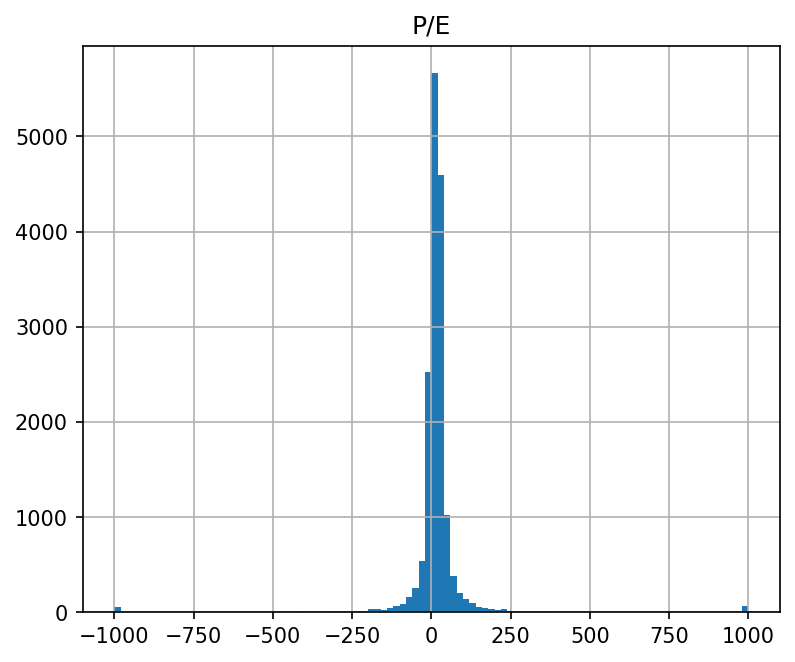

In [18]:
# See one of the distributions
k=X.keys()[2] # Try different numbers, 0-14.
X[k].hist(bins=100, figsize=(6,5))
plt.title(k);

In [19]:
X.describe()

,EV/EBIT,Op. In./(NWC+FA),P/E,P/B,P/S,Op. In./Interest Expense,Working Capital Ratio,RoE,ROCE,Debt/Equity,Debt Ratio,Cash Ratio,Asset Turnover,Gross Profit Margin,(CA-CL)/TA,RE/TA,EBIT/TA,Book Equity/TL
count,16615.000000,16615.000000,16615.000000,16615.000000,16615.000000,16615.000000,16615.000000,16615.000000,16615.000000,16615.000000,16615.000000,16615.000000,16615.000000,16615.000000,16615.000000,16615.000000,16615.000000,16615.000000
mean,13.528289,0.192562,17.837592,4.194910,8.116725,-23.009753,2.665822,0.044416,0.053361,2.358812,2.684440,1.370901,15.253625,0.469239,0.214008,-0.268450,0.032551,1.631390
std,69.063342,0.839153,119.539608,11.582241,45.552801,231.474964,2.959875,0.810825,0.322039,7.327742,3.044031,2.739077,81.175563,0.266463,0.260667,2.065762,0.241632,2.489388
min,-500.000000,-5.000000,-1000.000000,-50.000000,0.000000,-600.000000,0.000000,-5.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.500000,-20.000000,-2.000000,-2.000000
25%,6.497956,0.046898,3.160034,1.455739,0.821229,-0.947308,1.204664,-0.000390,0.025487,0.485470,1.434771,0.177445,2.085626,0.268180,0.040259,-0.107683,0.019478,0.434771
50%,13.388232,0.167820,17.259052,2.554668,1.724428,4.166794,1.836302,0.098388,0.090252,1.054664,1.848436,0.519486,5.603939,0.419361,0.178254,0.147247,0.068748,0.848436
75%,21.151210,0.352821,27.625453,4.632983,3.690925,14.119949,2.987487,0.188459,0.164518,2.020739,2.712056,1.345362,11.198560,0.649384,0.362197,0.404497,0.123938,1.712056
max,500.000000,5.000000,1000.000000,100.000000,500.000000,600.000000,30.000000,5.000000,2.000000,100.000000,50.000000,30.000000,2000.000000,1.000000,0.985311,2.000000,1.000000,20.000000


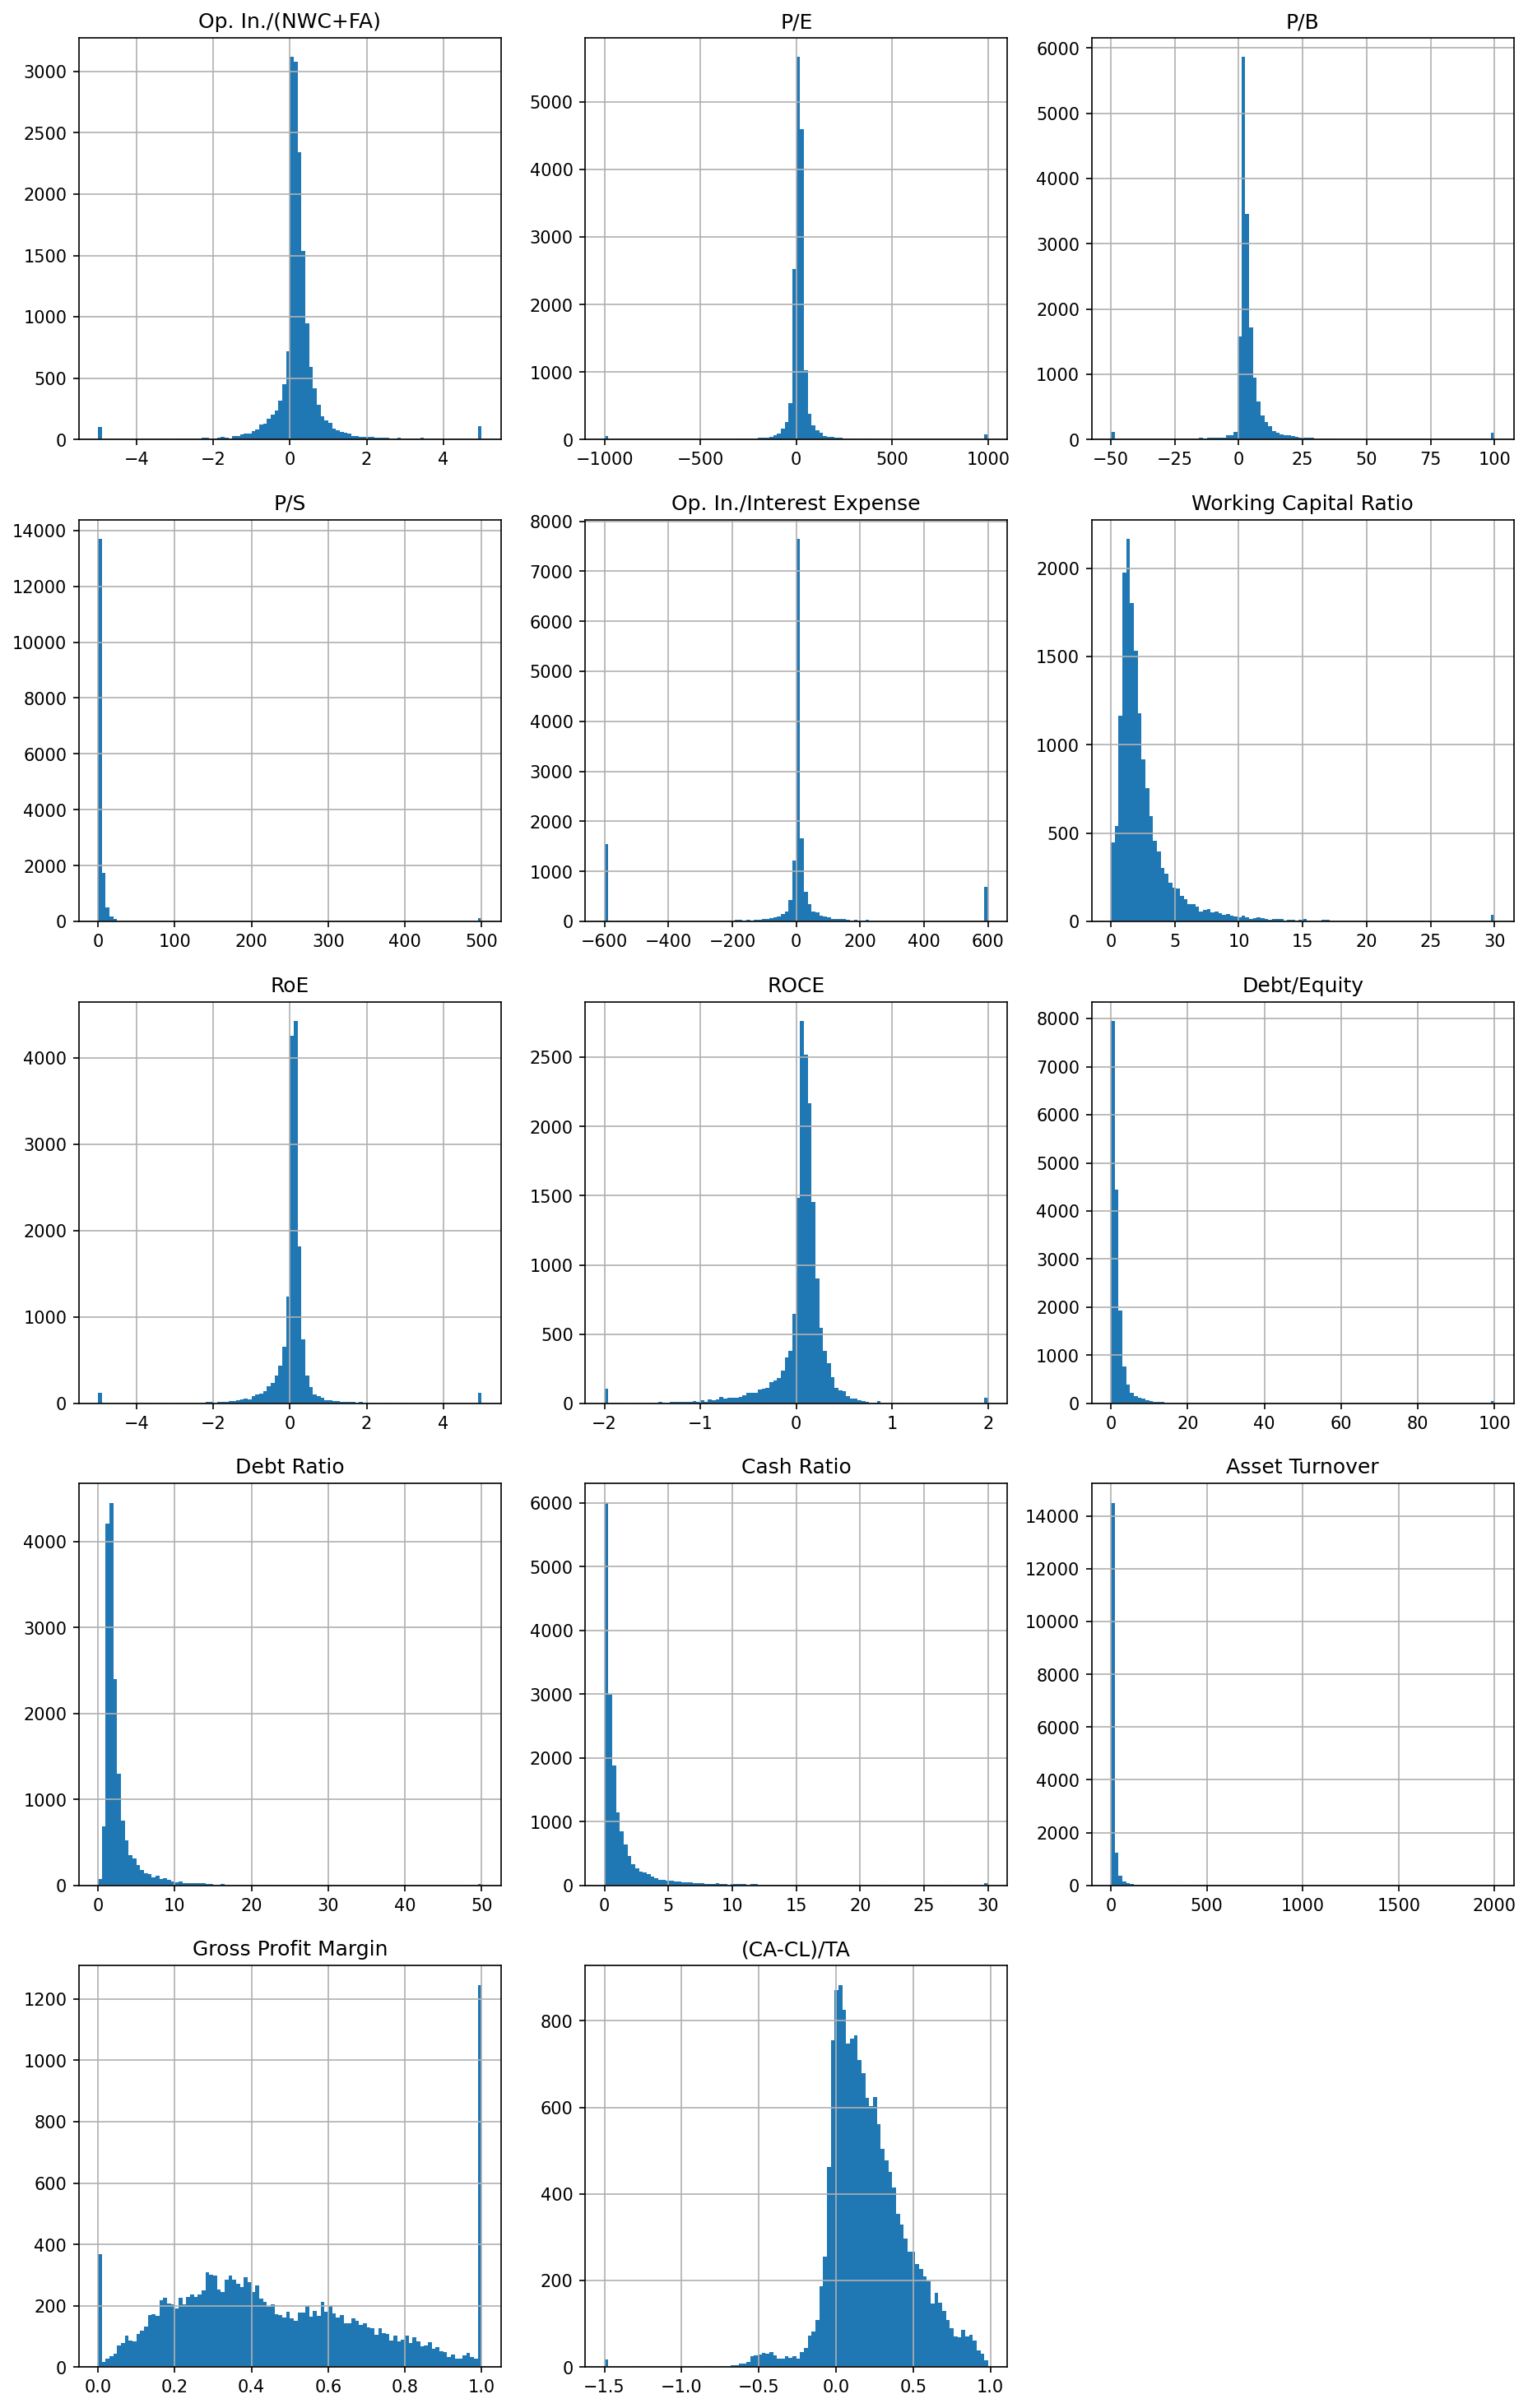

In [20]:
# Make a plot of the distributions.
cols, rows = 3, 5
plt.figure(figsize=(5*cols, 5*rows))

for i in range(1, cols*rows):
    if i<len(X.keys()):
        plt.subplot(rows, cols, i)
        k=X.keys()[i]
        X[k].hist(bins=100)
        plt.title(k);

In [21]:
y.to_csv("Annual_Stock_Price_Performance_Percentage.csv")
X.to_csv("Annual_Stock_Price_Fundamentals_Ratios.csv")

### Try out power transformer see if our data has good distributions
A lot of the algorithms won't work without appropriate transformation. We'll use the power transformer

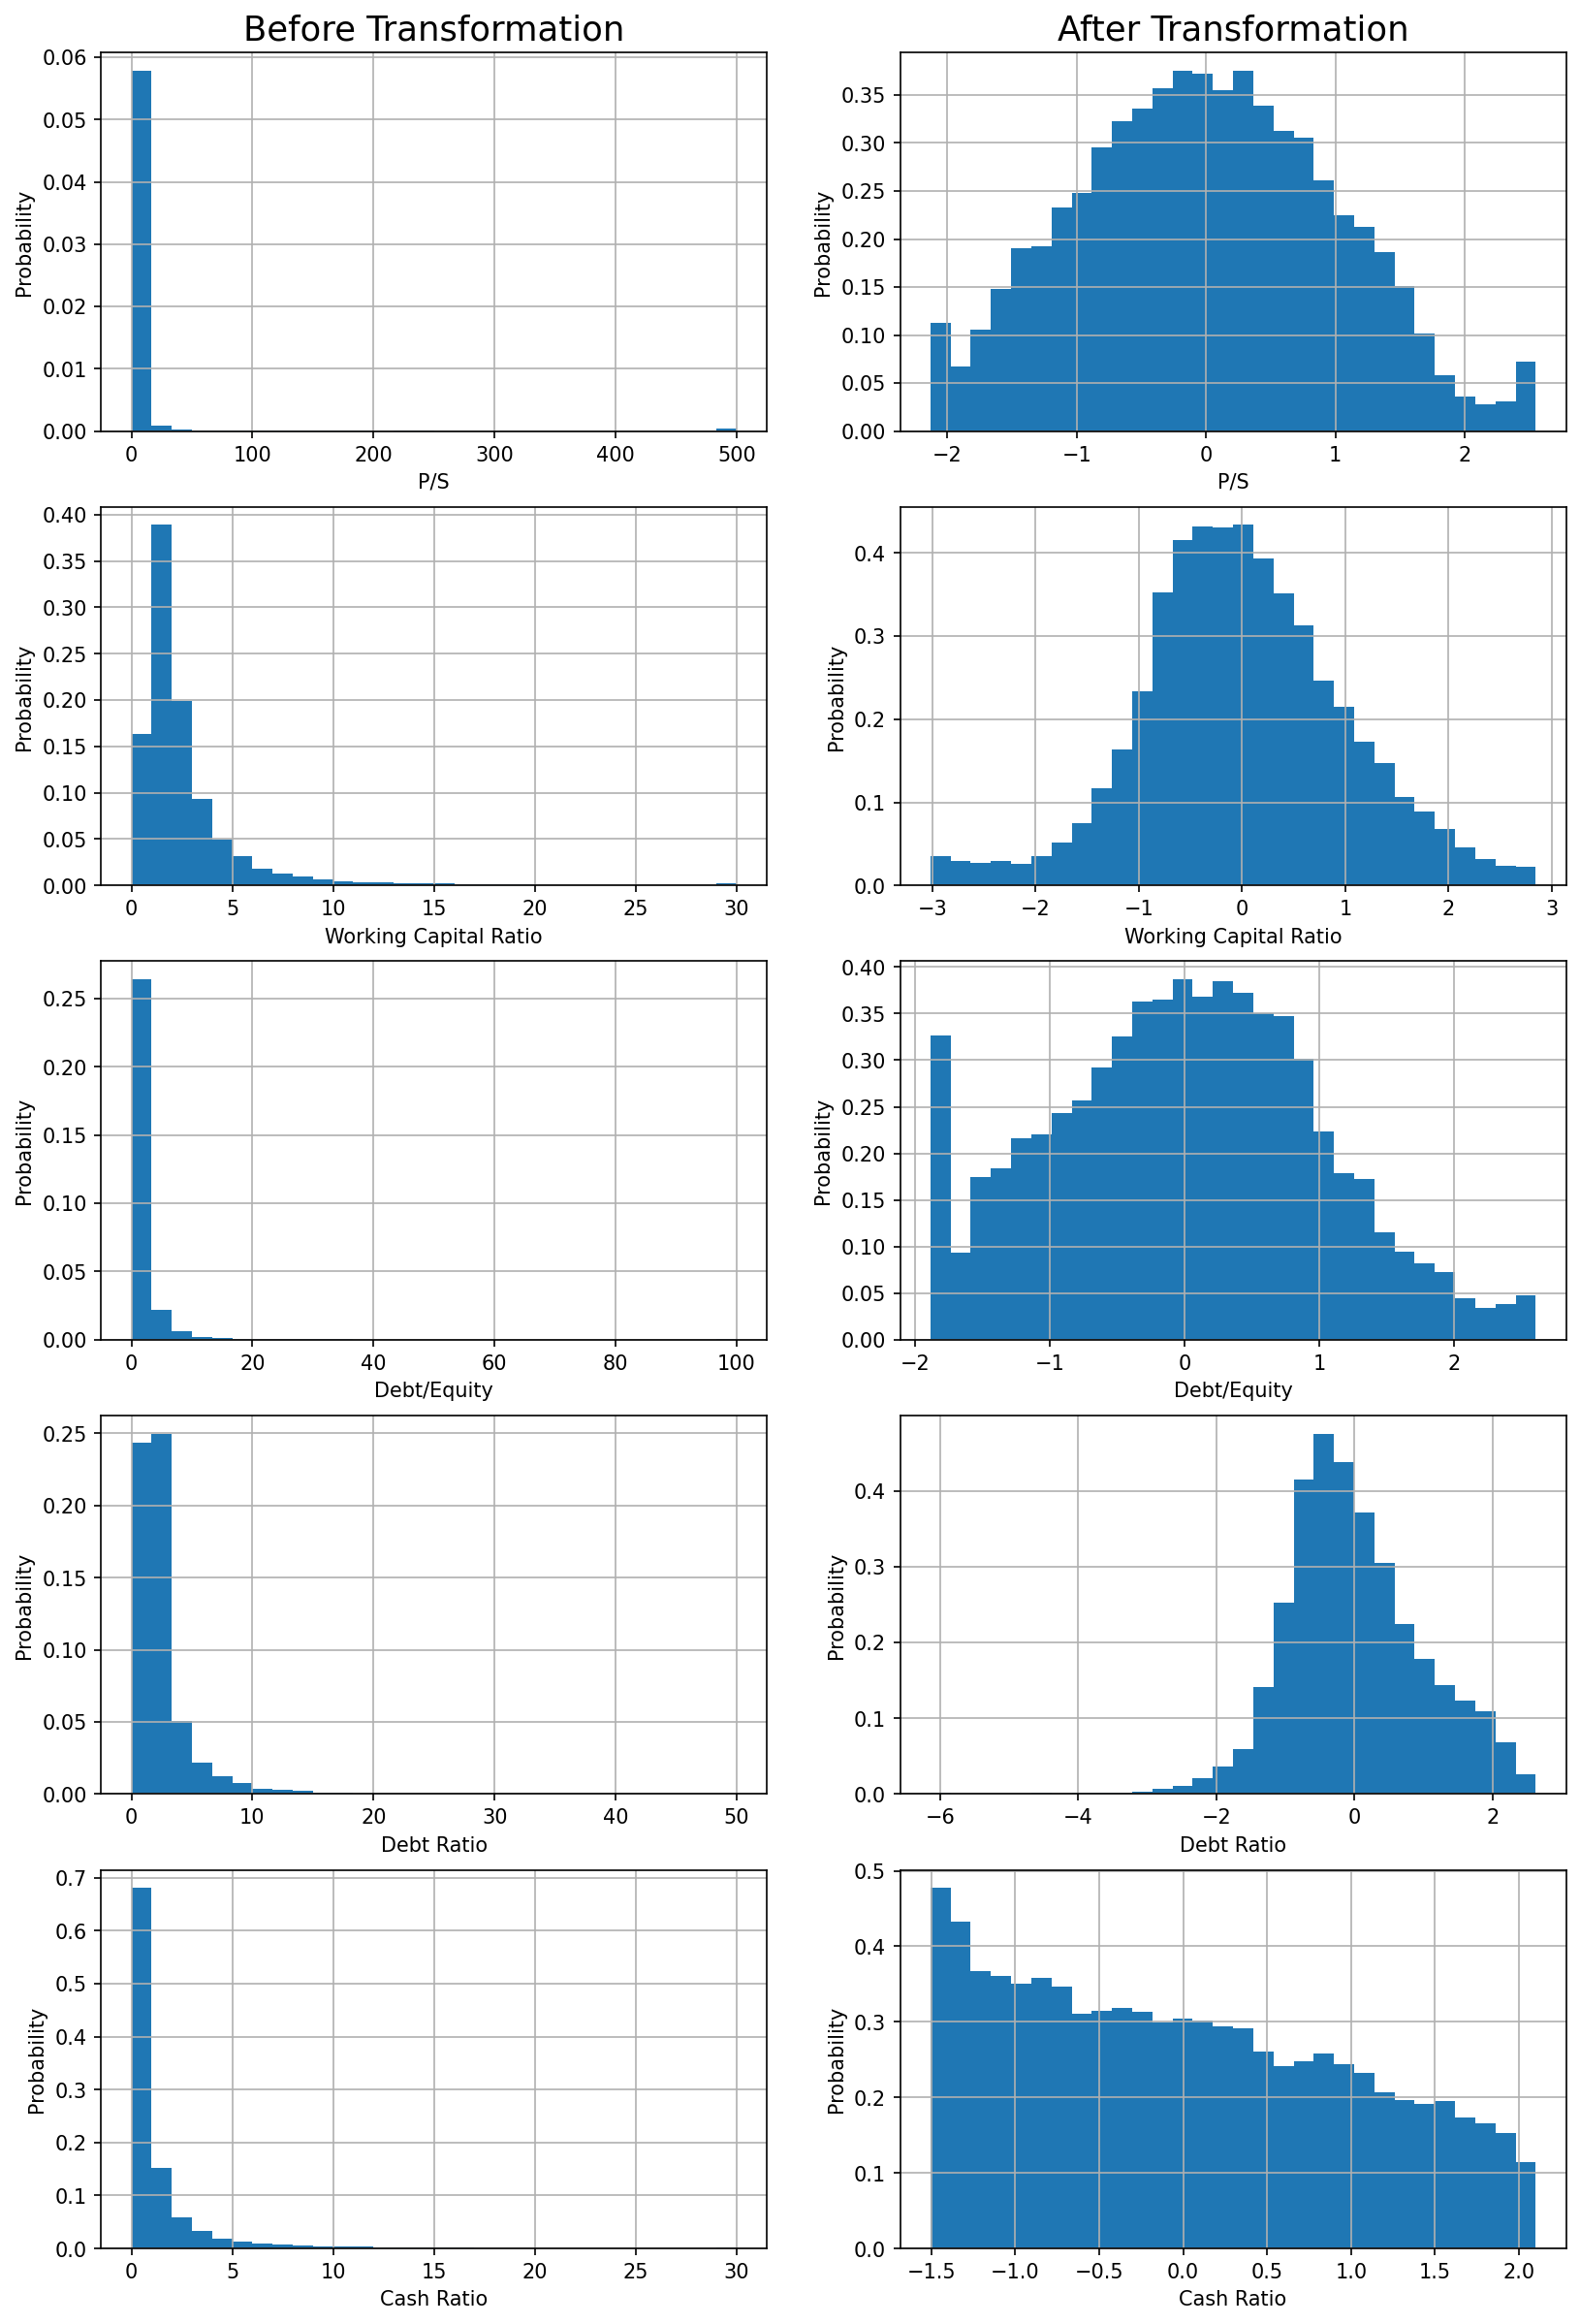

In [22]:
# Write code to plot out all distributions of X in a nice diagram
from sklearn.preprocessing import PowerTransformer
transformer = PowerTransformer()
X_t=pd.DataFrame(transformer.fit_transform(X), columns=X.keys())

def plotFunc(n, myDatFrame):
    myKey = myDatFrame.keys()[n]
    plt.hist(myDatFrame[myKey], density=True, bins=30)
    plt.grid()
    plt.xlabel(myKey)
    plt.ylabel('Probability')

plt.figure(figsize=(13,20))
plotsIwant=[4,6,9,10,11]

j=1
for i in plotsIwant:
    plt.subplot(len(plotsIwant),2,2*j-1)
    plotFunc(i,X)
    if j==1:
        plt.title('Before Transformation',fontsize=17)
    plt.subplot(len(plotsIwant),2,2*j)
    plotFunc(i,X_t)
    if j==1:
        plt.title('After Transformation',fontsize=17)
    j+=1
    
plt.savefig('Transformat_Dists.png', dpi=300)

# X Data for Final Stock Selection 2021/2022
Requires SimFin+ Bulk Download

In [22]:
X=pd.read_csv("Annual_Stock_Price_Fundamentals_Filtered_2021.csv", 
              index_col=0)

# Net Income fix, checked annual reports.
X['Net Income'] = X['Net Income_x'] 

fixNansInX(X)
addColsToX(X)
X=getXRatios(X)
fixXRatios(X)
X.to_csv("Annual_Stock_Price_Fundamentals_Ratios_2021.csv")

In [4]:
import pandas as pd
a = pd.read_csv('us-income-annual2.csv', delimiter=';')

In [5]:
a

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),...,Non-Operating Income (Loss),"Interest Expense, Net","Pretax Income (Loss), Adj.",Abnormal Gains (Losses),Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Extraordinary Gains (Losses),Net Income,Net Income (Common)
0,A,45846,USD,2008,FY,2008-10-31,2008-12-19,2010-12-20,363000000.0,371000000.0,...,20000000.0,-10000000.0,815000000,0.0,815000000,-122000000.0,693000000,NaN,693000000,693000000
1,A,45846,USD,2009,FY,2009-10-31,2009-12-21,2011-12-16,346000000.0,346000000.0,...,-40000000.0,-59000000.0,7000000,0.0,7000000,-38000000.0,-31000000,NaN,-31000000,-31000000
2,A,45846,USD,2010,FY,2010-10-31,2010-12-20,2012-12-20,347000000.0,353000000.0,...,-6000000.0,-76000000.0,560000000,132000000.0,692000000,-8000000.0,684000000,NaN,684000000,684000000
3,A,45846,USD,2011,FY,2011-10-31,2011-12-16,2013-12-19,347000000.0,355000000.0,...,-39000000.0,-72000000.0,1032000000,NaN,1032000000,-20000000.0,1012000000,NaN,1012000000,1012000000
4,A,45846,USD,2012,FY,2012-10-31,2012-12-20,2014-12-22,348000000.0,353000000.0,...,-76000000.0,-92000000.0,1043000000,NaN,1043000000,110000000.0,1153000000,NaN,1153000000,1153000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20353,ZYXI,171401,USD,2015,FY,2015-12-31,2016-03-31,2017-04-17,31271234.0,31271234.0,...,-510000.0,-503000.0,-2991000,NaN,-2991000,57000.0,-2934000,NaN,-2911000,-2911000
20354,ZYXI,171401,USD,2016,FY,2016-12-31,2017-04-18,2018-02-28,31271234.0,31271234.0,...,-556000.0,-352000.0,84000,NaN,84000,-15000.0,69000,NaN,69000,69000
20355,ZYXI,171401,USD,2017,FY,2017-12-31,2018-02-28,2019-02-26,32156000.0,33196000.0,...,-1450000.0,-1450000.0,7494000,NaN,7494000,-129000.0,7365000,NaN,7365000,7365000
20356,ZYXI,171401,USD,2018,FY,2018-12-31,2019-02-26,2019-02-26,32503000.0,34043000.0,...,-154000.0,-154000.0,10216000,NaN,10216000,-664000.0,9552000,NaN,9552000,9552000


In [6]:
a['Net Income'] = a['Net Income_x'] 

KeyError: 'Net Income_x'